# Training a model using sklearn


## Overview

This lab is a continuation of the guided labs in Module 3.

In this lab, you will split the data into three separate datasets:

- _Training Set_ - This will be used to train the model.
- _Validation Set_ - This will be used during training to validate the model.
- _Test Set_ - This will be held back and used to produce metrics after the model is trained. You will use this dataset in an upcoming lab.

With the split data, you will train a XGBoost model.

## Introduction to the business scenario

You work for a healthcare provider, and want to improve detection of abnormalities in orthopedic patients.

You are tasked with solving this problem by using machine learning (ML). You have access to a dataset that contains six biomechanical features and a target of _normal_ or _abnormal_. You can use this dataset to train an ML model to predict if a patient will have an abnormality.

## About this dataset

This biomedical dataset was built by Dr. Henrique da Mota during a medical residence period in the Group of Applied Research in Orthopaedics (GARO) of the Centre Médico-Chirurgical de Réadaptation des Massues, Lyon, France. The data has been organized in two different, but related, classification tasks.

The first task consists in classifying patients as belonging to one of three categories:

- _Normal_ (100 patients)
- _Disk Hernia_ (60 patients)
- _Spondylolisthesis_ (150 patients)

For the second task, the categories _Disk Hernia_ and _Spondylolisthesis_ were merged into a single category that is labeled as _abnormal_. Thus, the second task consists in classifying patients as belonging to one of two categories: _Normal_ (100 patients) or _Abnormal_ (210 patients).

## Attribute information:

Each patient is represented in the dataset by six biomechanical attributes that are derived from the shape and orientation of the pelvis and lumbar spine (in this order):

- Pelvic incidence
- Pelvic tilt
- Lumbar lordosis angle
- Sacral slope
- Pelvic radius
- Grade of spondylolisthesis

The following convention is used for the class labels:

- DH (Disk Hernia)
- Spondylolisthesis (SL)
- Normal (NO)
- Abnormal (AB)

For more information about this dataset, see the [Vertebral Column dataset webpage](http://archive.ics.uci.edu/ml/datasets/Vertebral+Column).

## Dataset attributions

This dataset was obtained from:
Dua, D. and Graff, C. (2019). UCI Machine Learning Repository (http://archive.ics.uci.edu/ml). Irvine, CA: University of California, School of Information and Computer Science.


# Lab setup

Because this solution is split across several labs in the module, you must run the following cells so that you can load the data.


## Importing the data

By running the following cells, the data will be imported and ready for use.

**Note:** The following cells represent the key steps in the previous labs.


In [1]:
import warnings, requests, zipfile, io
import pandas as pd
from scipy.io import arff
import xgboost as xgb

warnings.simplefilter("ignore")

In [2]:
f_zip = "http://archive.ics.uci.edu/ml/machine-learning-databases/00212/vertebral_column_data.zip"
r = requests.get(f_zip, stream=True)
Vertebral_zip = zipfile.ZipFile(io.BytesIO(r.content))
Vertebral_zip.extractall()

In [3]:
data = arff.loadarff("column_2C_weka.arff")
df = pd.DataFrame(data[0])

In [4]:
class_mapper = {b"Abnormal": 1, b"Normal": 0}
df["class"] = df["class"].replace(class_mapper)

# Step 1: Exploring the data

You will start with a quick reminder of the data in the dataset.

To get the most out of this lab, carefully read the instructions and code before you run the cells. Take time to experiment!


First, use **shape** to examine the number of rows and columns.


In [5]:
df.shape

(310, 7)

Next, get a list of the columns.


In [6]:
df.columns

Index(['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle',
       'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis', 'class'],
      dtype='object')

You can see the six biomechanical features, and that the target column is named _class_.


# Step 2: Preparing the data


For this lab, you must split the data into three datasets.

An internet search will show many different ways to split datasets. Many code samples that you might find will split the dataset into the _target_ and the _features_. Then, they will split each of those two datasets into three subsets, which results in a total of six datasets to track.


## Moving the target column position

XGBoost requires the training data to be in a single file. The file must have the target value be the first column.

Get the target column and move it to the first position.


In [7]:
cols = df.columns.tolist()
print(cols)
cols = cols[-1:] + cols[:-1]
print(cols)
df = df[cols]

['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle', 'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis', 'class']
['class', 'pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle', 'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis']


You should see that the **class** is now the first column.


In [8]:
df.columns

Index(['class', 'pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle',
       'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis'],
      dtype='object')

## Splitting the data

You will start by splitting the dataset into two datasets. You will use one dataset for training, and you will split the other dataset again for use with validation and testing.

You will use the _train_test_split function_ from the _scikit-learn library_, which is a free machine learning library for Python. It has many algorithms and useful functions, such as the one you will use.

- For more information about the function, see the [Train_test_split documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).
- For more information about scikit-learn, see the [scikit-learn guide](https://scikit-learn.org/stable/)

Because you don't have a lot of data, you want to make sure that the split datasets contain a representative amount of each class. Thus, you will use the _stratify_ switch. Finally, you will use a random number so that you can repeat the splits.


In [9]:
from sklearn.model_selection import train_test_split

train, test_and_validate = train_test_split(df, test_size=0.2, random_state=42, stratify=df["class"])

Next, split the _test_and_validate_ dataset into two equal parts.


In [10]:
test, validate = train_test_split(test_and_validate, test_size=0.5, random_state=42, stratify=test_and_validate["class"])

Examine the three datasets.


In [11]:
print(train.shape)
print(test.shape)
print(validate.shape)

(248, 7)
(31, 7)
(31, 7)


Now, check the distribution of the classes.


In [12]:
print(train["class"].value_counts())
print(test["class"].value_counts())
print(validate["class"].value_counts())

class
1    168
0     80
Name: count, dtype: int64
class
1    21
0    10
Name: count, dtype: int64
class
1    21
0    10
Name: count, dtype: int64


In [13]:
x = {
    "train": train.drop(columns=["class"]).to_numpy(),
    "test": test.drop(columns=["class"]).to_numpy(),
    "validate": validate.drop(columns=["class"]).to_numpy(),
}
y = {"train": train["class"].to_numpy(), "test": test["class"].to_numpy(), "validate": validate["class"].to_numpy()}

# Step 3: Training the model


In [14]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric="auc", verbosity=2)

In [15]:
xgb_model.fit(x["train"], y["train"])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

After the training is complete, you are ready to test and evaluate the model. However, you will do testing and validation in later labs.


# Metrics


In [16]:
y_test_pred = xgb_model.predict(x["test"])

In [17]:
from sklearn.metrics import confusion_matrix, classification_report

In [18]:
arr_conf_matrix = confusion_matrix(y["test"], y_test_pred)
arr_conf_matrix

array([[ 7,  3],
       [ 2, 19]])

In [19]:
print(classification_report(y["test"], y_test_pred))

              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.86      0.90      0.88        21

    accuracy                           0.84        31
   macro avg       0.82      0.80      0.81        31
weighted avg       0.84      0.84      0.84        31



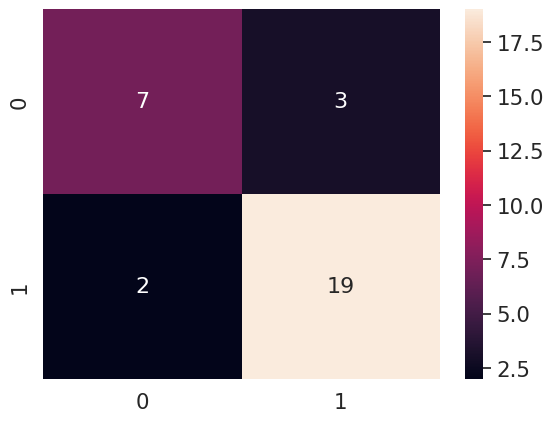

In [20]:
import seaborn as sn
import matplotlib.pyplot as plt


sn.set(font_scale=1.4)  # for label size
sn.heatmap(arr_conf_matrix, annot=True, annot_kws={"size": 16})  # font size

plt.show()

# Congratulations!

You have completed this lab, and you can now end the lab by following the lab guide instructions.
